In [2]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

import config, data, models, train, evaluate

In [5]:
reload(config)
from config import format_config

cfg = {
    # Data
    "data_dir": "../data/Sag",
    "basin_file": "sites.txt",
    "features": {"daily": ["gage_Q"],
                 "irregular": ["Blue", "Green", "Red", "Nir", "Swir1", "Swir2"],
                 "static": None, # All are used when None
                 "target": "tss"},
    "time_slice": ["1979-01-01", "2018-12-31"], 
    "split_time": "2010-01-01",
    "sequence_length": 30,
    "log_norm_cols": ["tss","gage_Q"],
    "clip_target_to_zero": True,
    
    # DataLoader
    "shuffle": True,
    "batch_size": 16,
    "data_subset": "train",
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": True,
    
    # Model
    "model": "eatransformer",
    "model_args": {"hidden_size": 64,
                   "intermediate_size": 64,
                   "num_layers": 2,
                   "num_heads": 2,
                   "dropout_p": 0.1,
                   "seed": 0}, 
    
    # Trainer
    "num_epochs": 100,
    "initial_lr": 0.001,
    "decay_rate": 0.01,
    "step_kwargs":{"loss": "mse",
                   "max_grad_norm": 2}, 
    
    # Outputs
    "quiet": False,  # Use to declutter the slurm output (removes tqdm)
    "log": False,
    "log_interval": 5
}
cfg = format_config(cfg)

In [6]:
# reload(data)
from data import TAPDataset

dataset = TAPDataset(cfg)

Loading Basins:   0%|          | 0/2 [00:00<?, ?it/s]

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Epoch:001:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:002:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:003:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:004:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:005:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:006:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:007:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:008:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:009:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:010:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:011:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:012:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:013:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:014:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:015:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:016:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:017:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:018:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:019:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:020:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:021:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:022:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:023:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:024:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:025:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:026:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:027:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:028:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:029:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:030:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:031:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:032:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:033:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:034:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:035:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:036:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:037:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:038:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:039:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:040:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:041:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:042:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:043:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:044:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:045:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:046:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:047:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:048:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:049:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:050:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:051:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:052:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:053:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:054:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:055:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:056:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:057:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:058:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:059:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:060:   0%|          | 0/8 [00:00<?, ?it/s]

Training finished or interrupted. Model state saved.


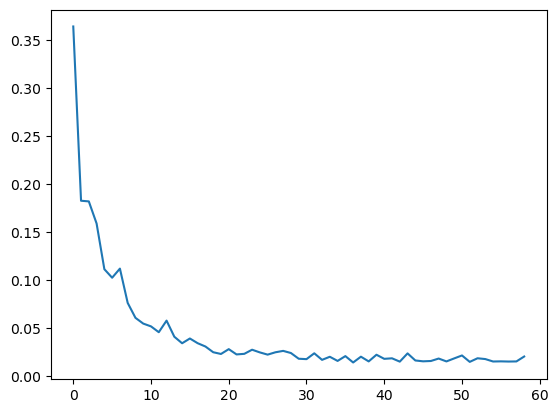

In [7]:
# reload(data)
from data import TAPDataLoader

reload(train)
from train import Trainer

# Specific to Transformer
cfg['model_args']['dynamic_in_size'] = len(dataset.daily_features) + len(dataset.irregular_features)
cfg['model_args']['static_in_size'] = len(dataset.static_features)
cfg['model_args']['max_length'] = cfg['sequence_length']

dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)
trainer.start_training()


In [46]:
trainer.opt_state[0].mu.encoder.embedder_block.daily_embedder.weight
trainer.opt_state[0]

ScaleByAdamState(count=Array(1673, dtype=int32), mu=EATransformer(
  encoder=Encoder(
    embedder_block=EmbedderBlock(
      daily_embedder=Linear(
        weight=f32[256,1],
        bias=f32[256],
        in_features=1,
        out_features=256,
        use_bias=True
      ),
      irregular_embedder=Linear(
        weight=f32[256,6],
        bias=f32[256],
        in_features=6,
        out_features=256,
        use_bias=True
      ),
      position_embedder=Embedding(
        num_embeddings=30,
        embedding_size=256,
        weight=f32[30,256]
      ),
      layernorm=LayerNorm(
        shape=(256,),
        eps=1e-05,
        use_weight=True,
        use_bias=True,
        weight=f32[256],
        bias=f32[256]
      ),
      dropout=Dropout(p=None, inference=None)
    ),
    layers=[
      TransformerLayer(
        attention_block=AttentionBlock(
          attention=MultiheadAttention(
            query_proj=Linear(
              weight=f32[256,256],
              bias=None,

In [ ]:
import optax

more_epochs = 150

trainer.load_state('epoch100')
loader_args['data_subset'] = 'train'
trainer.dataloader = TAPDataLoader(dataset, **loader_args)
trainer.lr_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.num_epochs += more_epochs
trainer.freeze_components('tealstm_i',True)
trainer.start_training() 

In [ ]:
lr_schedule = optax.exponential_decay(0.01, trainer.epoch+num_epochs, 0.001, transition_begin=trainer.epoch)
x = np.linspace(0,num_epochs*2)
y = lr_schedule(x)
plt.plot(x,y)

In [8]:
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()

cfg['data_subset'] = 'test'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results = predict(trainer.model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/205 [00:00<?, ?it/s]

{'mae': 0.01314103,
 'mse': 0.0005677324,
 'rmse': 0.023827136,
 'kge': 0.1904338529268529,
 'nse': -5.633537769317627}

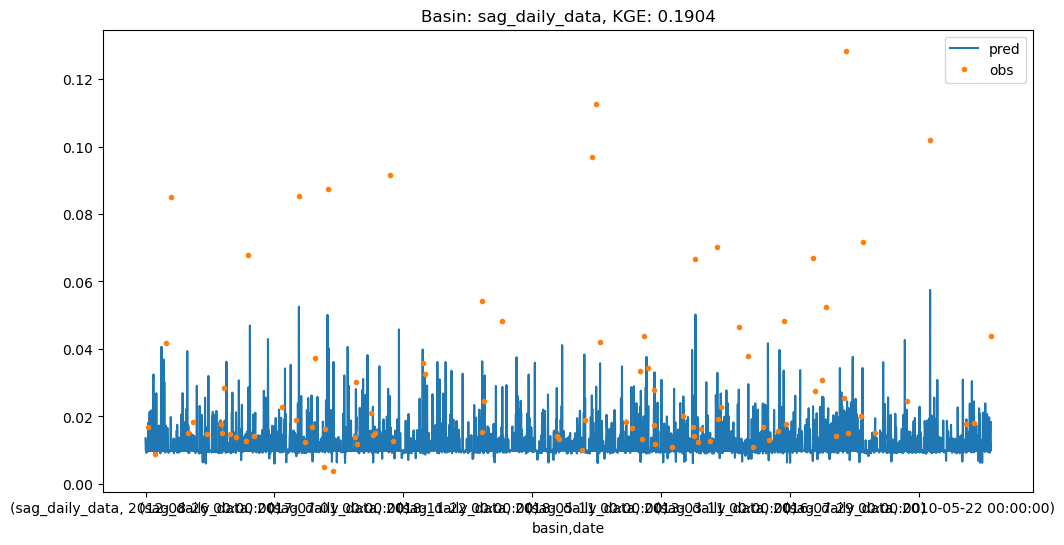

In [10]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

metrics = get_all_metrics(results['obs'],results['pred'])

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
# plt.ylim([0,500])
plt.show()

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [ ]:
from train import make_step
from tqdm.notebook import trange

# See if we can recreate the error... 
data = trainer.load_state("exceptions/epoch130_exception0")
for i in trange(1000):
    make_step(trainer.model, data['batch'], trainer.opt_state, trainer.optim,
              trainer.filter_spec, loss_name="mse", max_grad_norm=None, l2_weight=None)